In [1]:
import pandas as pd
import numpy as np
import joblib
import os

# Load the full feature set
df = pd.read_csv("../../../ML_Data/FINAL_GENUS_TAXA_CLR.csv")
y = df["Group"]
X = df.iloc[:, 1:-13]  # Select all features except the target and some trailing columns

# Define paths and parameters
base_dir = '../taxa_results/SFS-CV_RandomForest'
num_folds = 5
shap_values_test_all = []
shap_values_train_all = []

# Process each fold
for fold in range(1, num_folds + 1):
    fold_dir = os.path.join(base_dir, f'outer_fold_{fold}')
    
    # Load SHAP values for test and train sets
    shap_values_test_path = os.path.join(fold_dir, 'shap_values_test.pkl')
    shap_values_train_path = os.path.join(fold_dir, 'shap_values_train.pkl')
    
    # Load SHAP values
    shap_values_test = joblib.load(shap_values_test_path)
    shap_values_train = joblib.load(shap_values_train_path)
    
    # Convert SHAP values from list to array if they are stored as lists
    if isinstance(shap_values_test, list):
        shap_values_test = np.array(shap_values_test)
    if isinstance(shap_values_train, list):
        shap_values_train = np.array(shap_values_train)
    
    # Check if SHAP values are 3D (multi-class) and average across the class dimension
    if shap_values_test.ndim == 3:
        shap_values_test = np.mean(shap_values_test, axis=0)
    if shap_values_train.ndim == 3:
        shap_values_train = np.mean(shap_values_train, axis=0)
    
    # Initialize dataframes for full feature mapping with zeros, specifying dtype as float
    shap_test_full = pd.DataFrame(0.0, index=np.arange(shap_values_test.shape[0]), columns=X.columns)
    shap_train_full = pd.DataFrame(0.0, index=np.arange(shap_values_train.shape[0]), columns=X.columns)

    
    # Get the column names for the selected features in this fold
    test_features_fold = X.columns[:shap_values_test.shape[1]]
    train_features_fold = X.columns[:shap_values_train.shape[1]]
    
    # Fill in the SHAP values for the selected features only
    shap_test_full.loc[:, test_features_fold] = shap_values_test
    shap_train_full.loc[:, train_features_fold] = shap_values_train
    
    # Append to the list for averaging later
    shap_values_test_all.append(shap_test_full)
    shap_values_train_all.append(shap_train_full)

# Calculate the mean SHAP values across folds for test and train sets
shap_values_test_avg = pd.concat(shap_values_test_all).groupby(level=0).mean()
shap_values_train_avg = pd.concat(shap_values_train_all).groupby(level=0).mean()

# Save the averaged SHAP values to CSV for easy analysis
shap_values_test_avg.to_csv('avg_shap_values_test.csv', index=False)
shap_values_train_avg.to_csv('avg_shap_values_train.csv', index=False)

print("Averaged SHAP values saved to avg_shap_values_test.csv and avg_shap_values_train.csv")


Averaged SHAP values saved to avg_shap_values_test.csv and avg_shap_values_train.csv


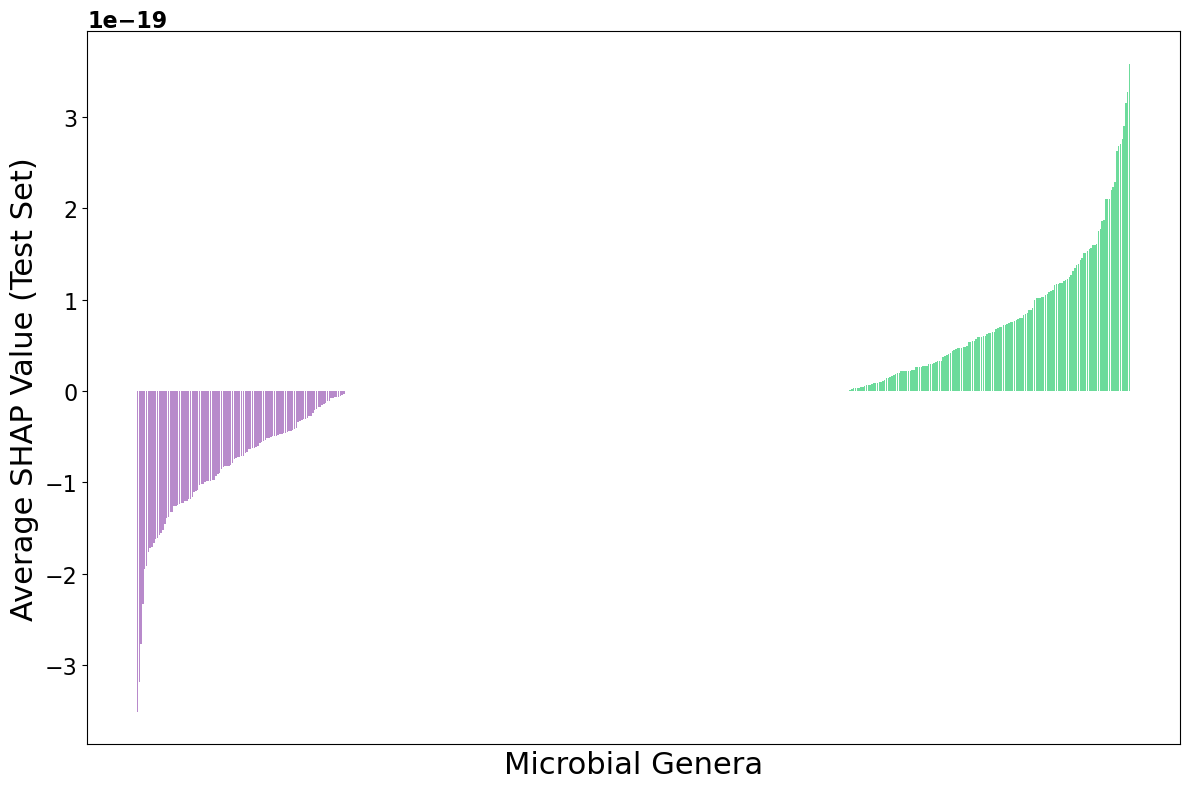

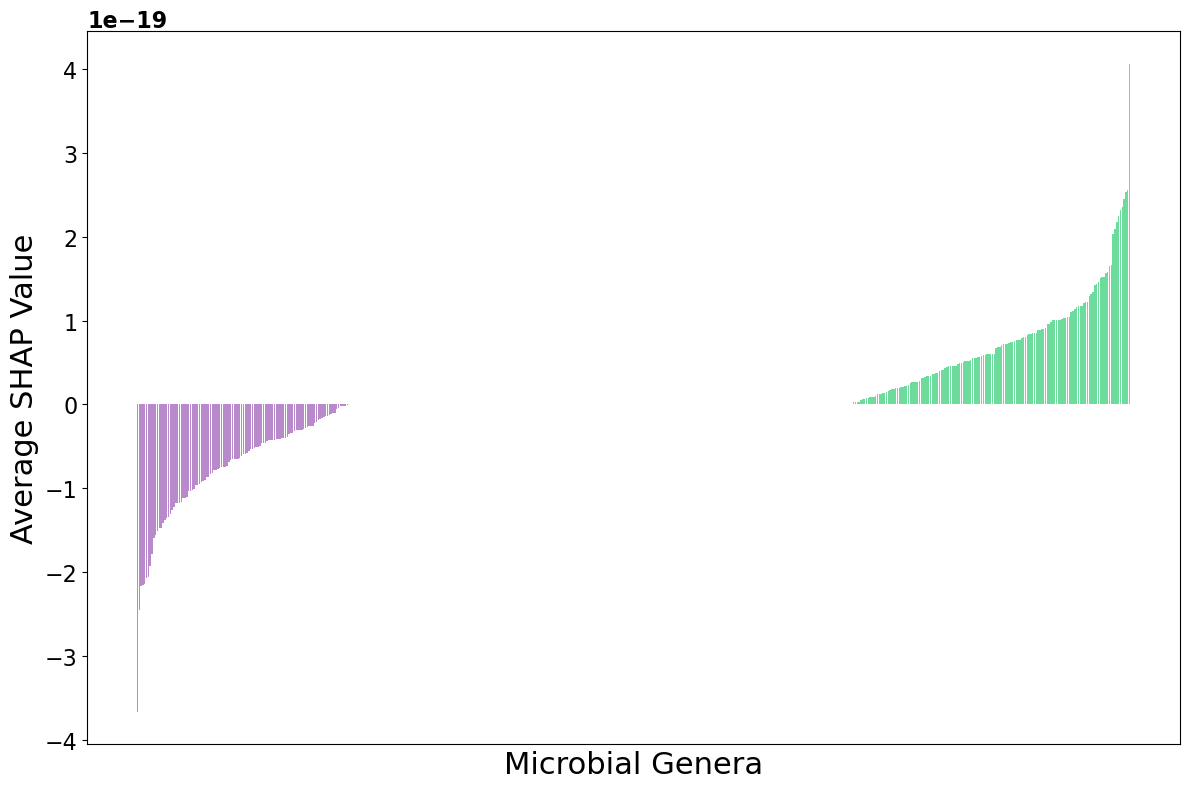

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
shap_values_test_avg = pd.read_csv("avg_shap_values_test.csv")
shap_values_train_avg = pd.read_csv("avg_shap_values_train.csv")

# Calculate mean for each feature across samples
shap_test_mean = shap_values_test_avg.mean(axis=0).sort_values()  # Sort from lowest to highest
shap_train_mean = shap_values_train_avg.mean(axis=0).sort_values()  # Sort from lowest to highest

# Define colors: red for negative values, blue for positive
test_colors = ['#9b59b6' if val < 0 else '#2ecc71' for val in shap_test_mean]
train_colors = ['#9b59b6' if val < 0 else '#2ecc71' for val in shap_train_mean]

# Plot for test set
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(shap_test_mean.index, shap_test_mean.values, color=test_colors, alpha=0.7)
ax.set_xlabel("Microbial Genera", fontsize=22)
ax.set_ylabel("Average SHAP Value (Test Set)", fontsize=22)
#ax.set_title("Average SHAP Values for Test Set Features", fontsize=24)
ax.set_xticks([])  # Remove x-axis feature labels
ax.tick_params(axis='y', labelsize=16)
ax.yaxis.offsetText.set_fontsize(16)
ax.yaxis.offsetText.set_fontweight('bold')  # Increase the font size of the scientific notation label
plt.tight_layout()
plt.savefig("avg_shap_values_test_plot.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot for train set
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(shap_train_mean.index, shap_train_mean.values, color=train_colors, alpha=0.7)
ax.set_xlabel("Microbial Genera", fontsize=22)
ax.set_ylabel("Average SHAP Value", fontsize=22)
#ax.set_title("Average SHAP Values for Train Set Features", fontsize=24)
ax.set_xticks([])  # Remove x-axis feature labels
ax.tick_params(axis='y', labelsize=16)
ax.yaxis.offsetText.set_fontsize(16)
ax.yaxis.offsetText.set_fontweight('bold')  # Increase the font size of the scientific notation label
plt.tight_layout()
plt.savefig("avg_shap_values_train_plot.png", format='png', dpi=600, bbox_inches='tight')
plt.show()


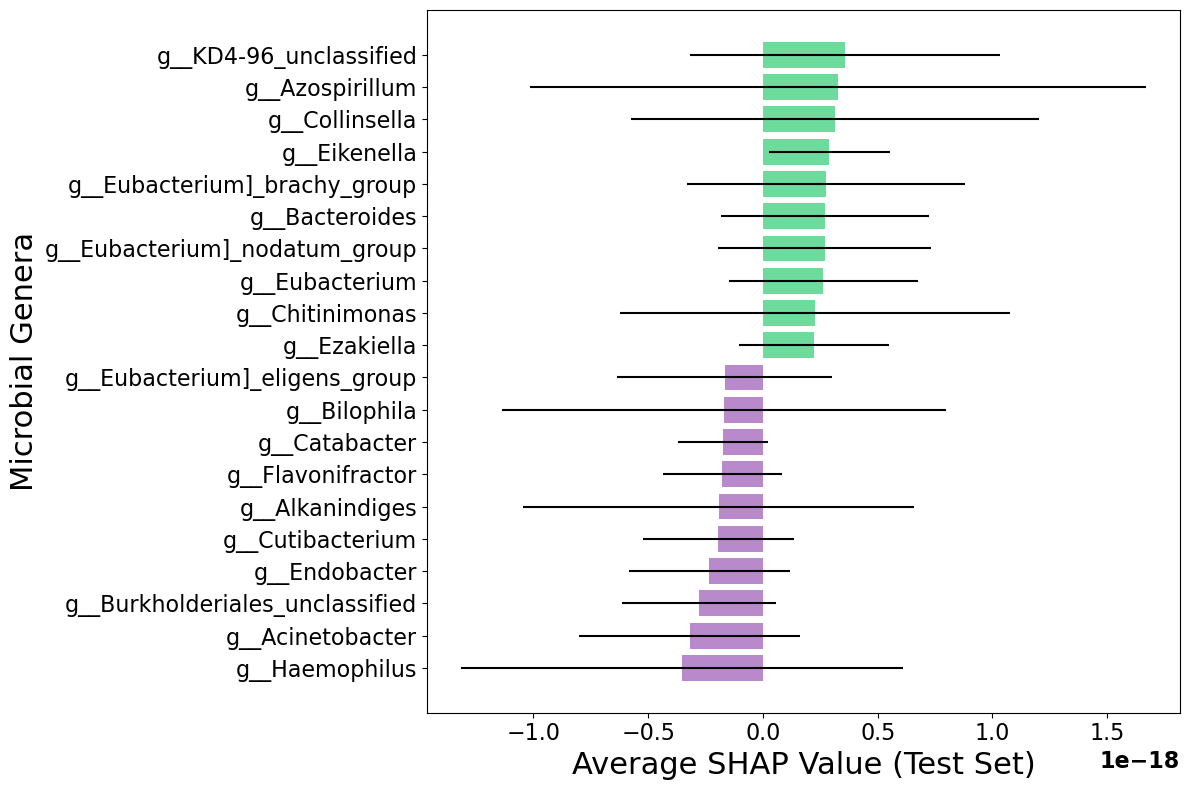

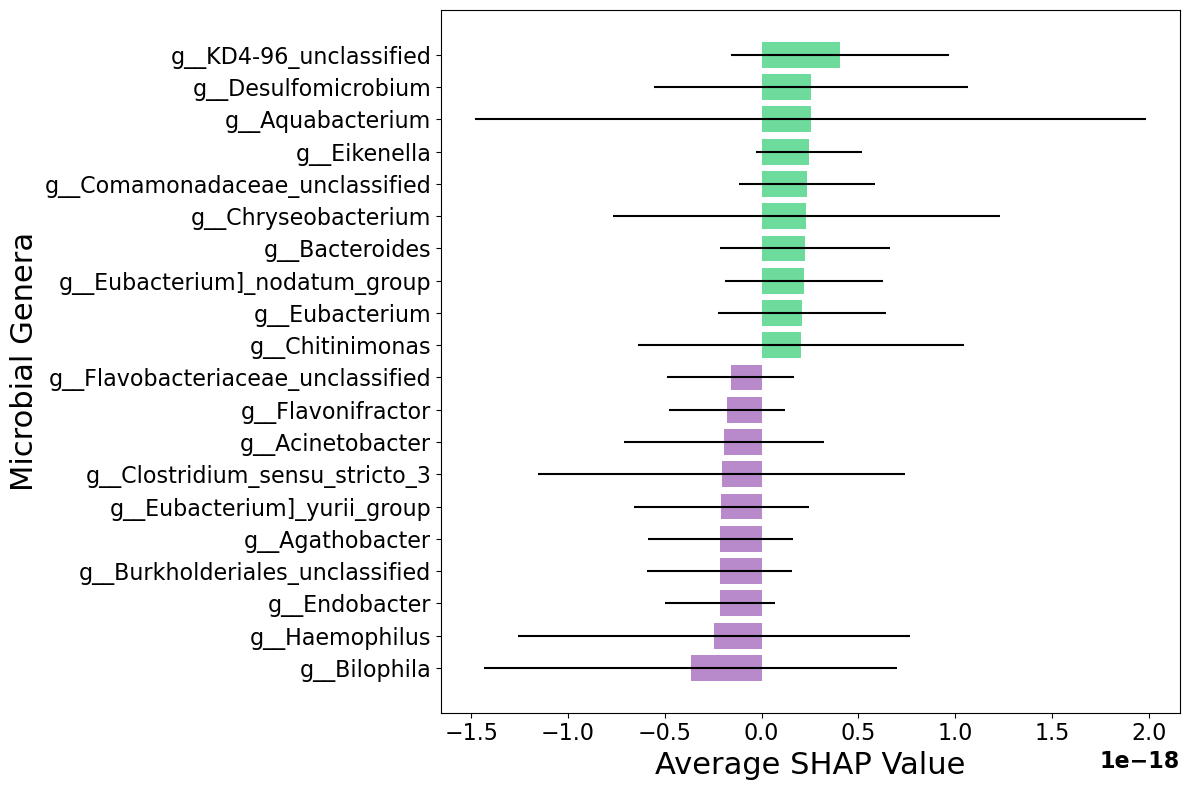

Top 10 lowest features (Test): ['g__Haemophilus', 'g__Acinetobacter', 'g__Burkholderiales_unclassified', 'g__Endobacter', 'g__Cutibacterium', 'g__Alkanindiges', 'g__Flavonifractor', 'g__Catabacter', 'g__Bilophila', 'g__Eubacterium]_eligens_group']
Top 10 highest features (Test): ['g__Ezakiella', 'g__Chitinimonas', 'g__Eubacterium', 'g__Eubacterium]_nodatum_group', 'g__Bacteroides', 'g__Eubacterium]_brachy_group', 'g__Eikenella', 'g__Collinsella', 'g__Azospirillum', 'g__KD4-96_unclassified']
Top 10 lowest features (Train): ['g__Bilophila', 'g__Haemophilus', 'g__Endobacter', 'g__Burkholderiales_unclassified', 'g__Agathobacter', 'g__Eubacterium]_yurii_group', 'g__Clostridium_sensu_stricto_3', 'g__Acinetobacter', 'g__Flavonifractor', 'g__Flavobacteriaceae_unclassified']
Top 10 highest features (Train): ['g__Chitinimonas', 'g__Eubacterium', 'g__Eubacterium]_nodatum_group', 'g__Bacteroides', 'g__Chryseobacterium', 'g__Comamonadaceae_unclassified', 'g__Eikenella', 'g__Aquabacterium', 'g__Desu

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate mean and standard deviation for each feature across samples
shap_test_mean = shap_values_test_avg.mean(axis=0)
shap_test_std = shap_values_test_avg.std(axis=0)
shap_train_mean = shap_values_train_avg.mean(axis=0)
shap_train_std = shap_values_train_avg.std(axis=0)

# Sort features from lowest to highest mean SHAP value
sorted_test_mean = shap_test_mean.sort_values()
sorted_train_mean = shap_train_mean.sort_values()

# Select the 10 lowest and 10 highest features for both test and train
top_10_lowest_test = sorted_test_mean[:10]
top_10_highest_test = sorted_test_mean[-10:]
top_10_lowest_train = sorted_train_mean[:10]
top_10_highest_train = sorted_train_mean[-10:]

# Combine for plotting
test_selected = pd.concat([top_10_lowest_test, top_10_highest_test])
train_selected = pd.concat([top_10_lowest_train, top_10_highest_train])

# Corresponding standard deviations
test_selected_std = shap_test_std[test_selected.index]
train_selected_std = shap_train_std[train_selected.index]

# Plot for test set (horizontal bars)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(test_selected.index, test_selected.values, xerr=test_selected_std.values,
        color=['#9b59b6' if val < 0 else '#2ecc71' for val in test_selected], alpha=0.7)
ax.set_xlabel("Average SHAP Value (Test Set)", fontsize=22)
ax.set_ylabel("Microbial Genera", fontsize=22)
#ax.set_title("Top 10 Lowest and Highest SHAP Values (Test Set)", fontsize=24)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.offsetText.set_fontsize(16)  # Increase font size of x-axis scientific notation label
# Set the x-axis offset text font weight to bold
ax.xaxis.offsetText.set_fontweight('bold')
plt.tight_layout()
plt.savefig("top_10_shap_values_test_plot.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot for train set (horizontal bars)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(train_selected.index, train_selected.values, xerr=train_selected_std.values,
        color=['#9b59b6' if val < 0 else '#2ecc71' for val in train_selected], alpha=0.7)
ax.set_xlabel("Average SHAP Value", fontsize=22)
ax.set_ylabel("Microbial Genera", fontsize=22)
#ax.set_title("Top 10 Lowest and Highest SHAP Values (Train Set)", fontsize=24)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.offsetText.set_fontsize(16)  # Increase font size of x-axis scientific notation label
# Set the x-axis offset text font weight to bold
ax.xaxis.offsetText.set_fontweight('bold')
plt.tight_layout()
plt.savefig("top_10_shap_values_train_plot.png", format='png', dpi=600, bbox_inches='tight')
plt.show()

# Print the feature names of the 10 highest and 10 lowest for both test and train sets
print("Top 10 lowest features (Test):", list(top_10_lowest_test.index))
print("Top 10 highest features (Test):", list(top_10_highest_test.index))
print("Top 10 lowest features (Train):", list(top_10_lowest_train.index))
print("Top 10 highest features (Train):", list(top_10_highest_train.index))
